
This script generates hillslope mesh with a varying organic layer thickness at the top.

In [16]:
%matplotlib inline

In [9]:
# global parameters
dx = 10
outlet_elevation = 0

# run-specific parameters
hillslope_length = 1000
hillslope_slope = 0.1
toeslope_length = 200
toeslope_slope = 0.01

hillslope_acrotelm = 0.1
hillslope_catotelm = 0.1
toeslope_acrotelm = 0.3
toeslope_catotelm = 0.1

In [10]:
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools','meshing_ats'))
import meshing_ats

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
# global derived parameters
n_hillslope = int(round(hillslope_length / dx))
n_toeslope = int(round(toeslope_length/dx))
n_total = n_hillslope + n_toeslope

hillslope_length = n_hillslope * dx
toeslope_length = n_toeslope * dx
total_length = hillslope_length + toeslope_length



# of cells: 120


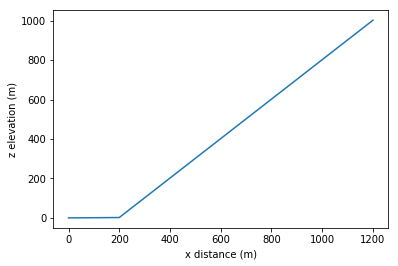

In [12]:

xs = np.linspace(0,total_length,n_total+1)

def z_of_x(x):
    z = outlet_elevation
    z += min(x, toeslope_length) * toeslope_slope
    z += max(0, min(x - toeslope_length, hillslope_length))
    return z
        
zs = np.array([z_of_x(x) for x in xs])

plt.plot(xs,zs); plt.xlabel('x distance (m)'); plt.ylabel('z elevation (m)')
m2 = meshing_ats.Mesh2D.from_Transect(xs,zs)
print('# of cells:', m2.num_cells())

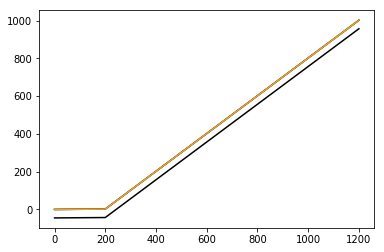

In [13]:
# Changing organic layer thickness 
acrotelm_thickness = np.where(xs < toeslope_length, toeslope_acrotelm, hillslope_acrotelm)
catotelm_thickness = np.where(xs < toeslope_length, toeslope_catotelm, hillslope_catotelm)

plt.plot(xs, zs, 'g')
plt.plot(xs, zs - acrotelm_thickness, 'b')
plt.plot(xs, zs - acrotelm_thickness - catotelm_thickness, 'orange')
plt.plot(xs, zs - 45, 'k')
plt.show()

In [ ]:
# preparing layer extrusion data for meshing_ats
#
# Meshes are extruded in the vertical by "layer", where a layer may 
# consist of multiple cells in the z direction.  These layers are 
# logical unit to make construction easier, and may or may not 
# correspond to material type (organic/mineral soil).
# 
# The extrusion process is then given four lists, each of length
# num_layers.
#
layer_types = []  # a list of strings that tell the extruding 
                  # code how to do the layers.  See meshing_ats 
                  # documentation for more, but here we will use
                  # only "constant", which means that dz within
                  # the layer is constant.

layer_data = []   # this data depends upon the layer type, but
                  # for constant is the thickness of the layer

layer_ncells = [] # number of cells (in the vertical) in the layer.
                  # The dz of each cell is the layer thickness / number of cells.

layer_mat_ids = []# The material ID.  This may be either a constant int (for
                  # unform layering) or an array of size [ncells_vertical x ncells_horizontal] in the layer 
                  # where each entry corresponds to the material ID of that cell.

layer_depth = []  # used later to get the mat ids right, just for bookkeeping
        
# here we will only use 1 cell per layer, so layer thickness = dz.
# We will also telescope the mesh, starting at 1cm grid cell and growing it larger in each layer.
dz = .01
i = 0
current_depth = 0
while dz < 2:
    if i<=20:            #organic
        dz *= 1.2
    elif (20<i)&(i<=26): #mineral
        dz *= 1.4
    else:                #bedrock
        dz *= 1.5
    layer_types.append("constant")
    layer_data.append(dz)
    layer_ncells.append(1)
    current_depth += dz
    layer_depth.append(current_depth)
    i += 1
    
# now add in a bunch of cells to reach 45 m, of equal dz that is ~2m.
num_of_layers=len(layer_data)
layer_types.append('constant')
layer_data.append(45 - sum(layer_data))  # note sum(layer_data) == the total mesh thickness at this point
layer_ncells.append(int(np.floor(layer_data[-1]/dz)))
layer_depth.append(45)


In [ ]:
# allocate 2D matrix with cols=#cells, rows=21
mat_ids=np.zeros((m2.num_cells(), 21), 'i')
for i in range(m2.num_cells()):
    for j in range(21): # after layer 20 everything is bedrock
        if (layer_depth[j] < org_layer_thickness[i]):
            mat_ids[i,j]=1001
        else:
            mat_ids[i,j]=1002
            
# filling out layer_mat_ids
layer_mat_ids = []
for j in range(21):
    layer_mat_ids.append(mat_ids[:,j])
for j in range(21,sum(layer_ncells)):
    layer_mat_ids.append(101*np.ones((100,),'i'))

print '# of rows, # of cells:', np.shape(layer_mat_ids)

In [ ]:
# make the mesh, save it as an exodus file
m3 = meshing_ats.Mesh3D.extruded_Mesh2D(m2, layer_types,layer_data, layer_ncells, layer_mat_ids)
m3.write_exodus("test_organic_highres.exo")

In [ ]:
# Make a column that is the same as the deepest organic layer thickness for use in spinup.
# 1 km long hillslope, 10% slope
xc = np.array([0,1])
zc = np.array([0,0])
m2c = meshing_ats.Mesh2D.from_Transect(xc,zc)
print '# of cells: ', m2c.num_cells()

In [ ]:
column_mat_ids = [lmi[50] for lmi in layer_mat_ids]
print column_mat_ids

In [ ]:
m3c = meshing_ats.Mesh3D.extruded_Mesh2D(m2c, layer_types,layer_data, layer_ncells, column_mat_ids)
m3c.write_exodus("test_organic_highres_column.exo")